In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
import time
import sampler
import display
import pprint

# Goal 1

In [12]:
def HouseholdDecomp(B):
    """
    inputs:
    B: np.array
        n x k matrix to be factored (with k <= n)

    returns Q, R
    Q: np.array
        n x k matrix
    R: np.array 
        k x k matrix
    """
    n, k = B.shape
    assert (n >= k), "n < k, precondition violated"
    
    Q = np.eye(n)
    R = B.copy().astype(float)
    for i in range(k):
        v = R[i : n, i].copy()
        v[0] += np.sign(v[0]) * np.linalg.norm(v)
        norm_v = np.linalg.norm(v)
        if norm_v == 0:
            continue
        v = v / norm_v
        v = v[ : , None]
        R[i : n, i : k] -= 2 * v @ (v.T @ R[i : n, i : k])
        Q[i : n, : ] -= 2 * v @ (v.T @ Q[i : n, : ])
        
    Q = Q[ : k].T
    R = R[ : k]
    assert (Q.shape == (n, k))
    assert (R.shape == (k, k))
    return Q, R

## Householder Correctness

In [3]:
def HouseholdTest(samples = 1000, tolerance = 1e-7):
    errors = 0
    for i in range(samples):
        A, (m, n) = sampler.r_mat_range(5, 50, 5, 50)
        if (m < n):
            A = A.T
        Q, R = HouseholdDecomp(A)
        if not np.allclose(Q @ R, A, atol=tolerance):
            errors += 1
    return errors

In [4]:
samples = 1000
print (f'Error percentage: {HouseholdTest(samples) / samples}')

Error percentage: 0.0


## Householder Scaling Analysis

### Scaling on random $m\times n$ matrices, $m\geq n$.

In [5]:
def compute_household_random(ns):
    times = []
    # every two is m,n pair
    _ns = []
    for m, n in zip(*[iter(ns)]*2):
        A = None
        if m > n:
            A = sampler.r_mat(m, n)
        else:
            A = sampler.r_mat(n, m)
        start = time.perf_counter_ns()
        Q, R = HouseholdDecomp(A)
        end = time.perf_counter_ns()
        times.append(end - start)
        _ns.append(m * n * n)

    return _ns, times, (Q, R)

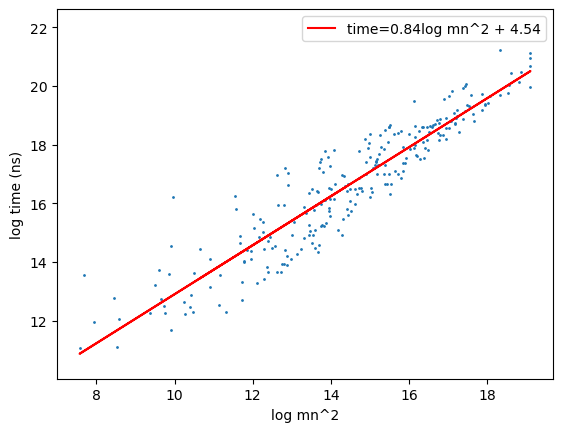

In [6]:
display.display(n_lo=5, n_hi=200, compute=compute_household_random, sampler="Exp", samples=500,axx_name="log mn^2", axy_name="log time (ns)", scientific=False)


### Scaling on random tall skinny $10n\times n$ matrices

In [7]:
def compute_household_skinny(ns):
    times = []
    _ns = []
    for n in ns:
        A = sampler.r_mat(10 * n, n)
        start = time.perf_counter_ns()
        Q, R = HouseholdDecomp(A)
        end = time.perf_counter_ns()
        times.append(end - start)
        _ns.append(10 * n * n * n)

    return _ns, times, (Q,R)

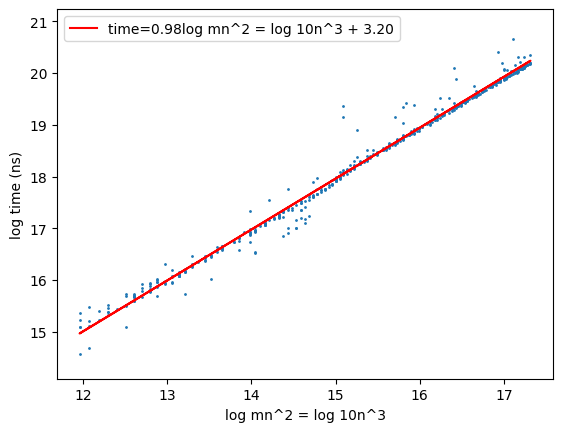

In [8]:
display.display(n_lo=25, n_hi=150, compute=compute_household_skinny, samples=500,axx_name="log mn^2 = log 10n^3", axy_name="log time (ns)", scientific=False)


### Scaling on random square $n\times n$ matrices

In [7]:
def compute_household_square(ns):
    times = []
    # every two is m,n pair
    for n in ns:
        A = sampler.r_square_mat(n)
        start = time.perf_counter_ns()
        Q, R = HouseholdDecomp(A)
        end = time.perf_counter_ns()
        times.append(end - start)

    return ns, times, (Q,R)

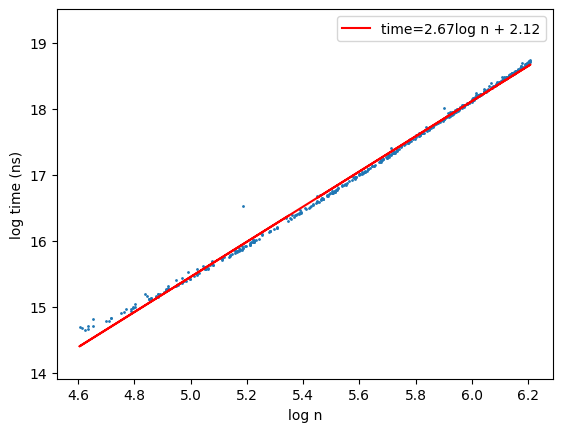

In [10]:
display.display(n_lo=100, n_hi=500, compute=compute_household_square, samples=500,axx_name="log n", axy_name="log time (ns)", scientific=False)

# Goal 2

## Algorithm 1: Alternating Least Squares, without regularization

In [14]:
def ALS(A, k, max_iter = 100, tolerance=1e-4):
    """
    A: n1 x n2 matrix
    k: int
        rank
    returns: W,Z
    """
    n1, n2 = A.shape
    W = sampler.r_mat(n1, k)
    Z = sampler.r_mat(n2, k)
    prev_norm = np.inf
    for _ in range(max_iter):
        Qz, Rz = HouseholdDecomp(Z)
        W = scipy.linalg.solve_triangular(Rz, Qz.T @ A.T, check_finite=False).T
        Qw, Rw = HouseholdDecomp(W)
        Z = scipy.linalg.solve_triangular(Rw, Qw.T @ A, check_finite=False).T
        new_norm = np.linalg.norm(A - W @ Z.T, ord='fro') ** 2
        if abs(new_norm - prev_norm) < tolerance:
            break
        prev_norm = new_norm
    return W, Z

# Goal 3

In [15]:
from PIL import Image

## Original image

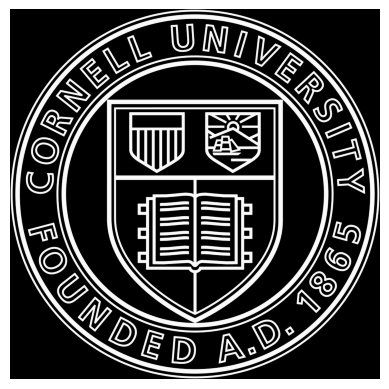

In [75]:
C = np.loadtxt('Data/Cornell.csv', delimiter=',')
k = 75
plt.imshow(C, cmap='Greys')
plt.axis('off')
plt.show()

## ALS Approximation

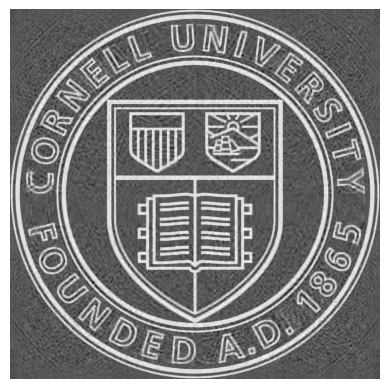

In [76]:
W,Z = ALS(C, k, max_iter=100)
plt.imshow(W @ Z.T, cmap='Greys')
plt.axis('off')
plt.show()

## SVD Approximation

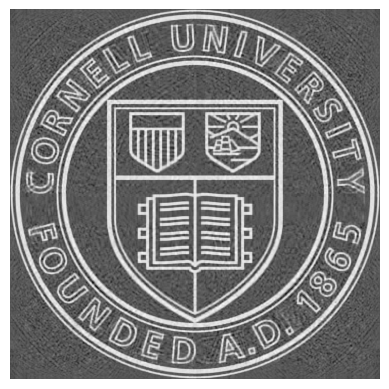

In [77]:
U,s,V = scipy.linalg.svd(C)
plt.imshow(U[ : , : k] @ np.diag(s[ : k]) @ V[ : k, : ], cmap='Greys')
plt.axis('off')
plt.show()

# Question 1

### Answer

# Goal 4

## Algorithm 2: Alternating Least Squares with regularization

In [121]:
def ALS_regularized(A, k, omega, beta, max_iter = 100, tolerance=1e-4):
    """
    A: n1 x n2 matrix
    k: int
    omega: mask matrix
    beta: float
    returns: W,Z
    """
    n1, n2 = A.shape
    W = sampler.r_mat(n1, k)
    Z = sampler.r_mat(n2, k)
    # losses = []

    for it in range(max_iter):
        for j in range(n2):
            observed_rows, = np.where(omega[:,j] == 1)
            # print(observed_rows)
            if len(observed_rows) == 0:
                Z[j, :] = np.zeros(k)
            else:
                W_sub = W[observed_rows, :]
                A_sub = A[observed_rows, j]
                # print(W_sub.shape, A_sub.shape)
                # print((beta * np.eye(k)).shape, np.zeros(k).shape)
                M = np.vstack([W_sub, beta * np.eye(k)])
                b = np.concatenate([A_sub, np.zeros(k)])
                Q, R = HouseholdDecomp(M)
                Z[j, :] = scipy.linalg.solve_triangular(R, Q.T @ b, check_finite=False)
        for i in range(n1):
            observed_cols, = np.where(omega[i, :] == 1)
            if len(observed_cols) == 0:
                W[i, :] = np.zeros(k)
            else:
                Z_sub = Z[observed_cols, :]
                A_sub = A[i, observed_cols]
                M = np.vstack([Z_sub, beta * np.eye(k)])
                b = np.concatenate([A_sub, np.zeros(k)])
                Q, R = HouseholdDecomp(M)
                W[i, :] = scipy.linalg.solve_triangular(R, Q.T @ b, check_finite=False)

    return W, Z

# Goal 5

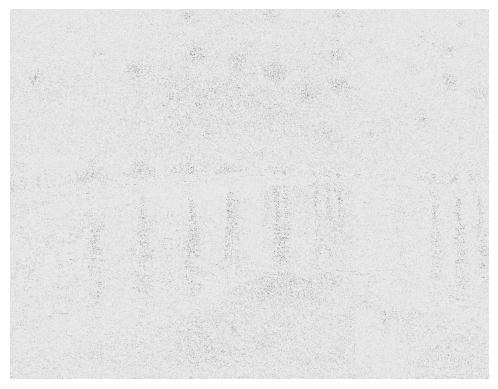

KeyboardInterrupt: 

In [134]:
img1 = np.loadtxt('Data/Image1.csv', delimiter=',')
mask1 = np.loadtxt('Data/Mask1.csv', delimiter=',')
# plt.imshow(np.log(img1 * mask1 + 0.5) + 100000, cmap='Greys')
plt.imshow(img1 * mask1, cmap='Greys')
plt.axis('off')
plt.show()
# print(mask1)
W1, Z1 = ALS_regularized(img1, 30, mask1, 0.1) 
plt.imshow(W1 @ Z1.T, cmap='Greys')
plt.axis('off')
plt.show()

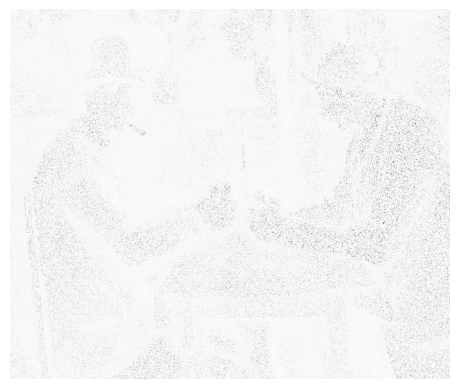

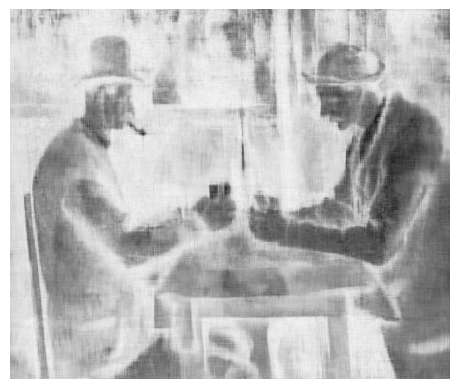

In [126]:
img2 = np.loadtxt('Data/Image2.csv', delimiter=',')
mask2 = np.loadtxt('Data/Mask2.csv', delimiter=',')
# plt.imshow(np.log(img2 * mask2 + 1) + 10000000, cmap='Greys')
plt.imshow(img2 * mask2, cmap='Greys')
plt.axis('off')
plt.show()
W2, Z2 = ALS_regularized(img2, 70, mask2, 0.5, max_iter=50) 
plt.imshow(W2 @ Z2.T, cmap='Greys')
plt.axis('off')
plt.show()

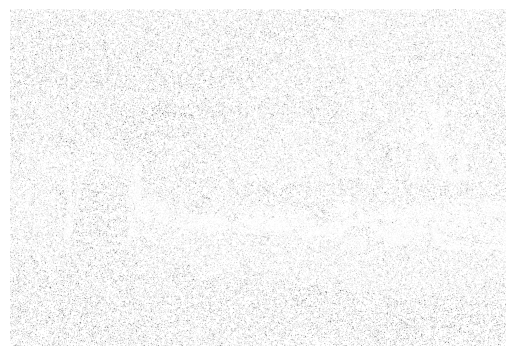

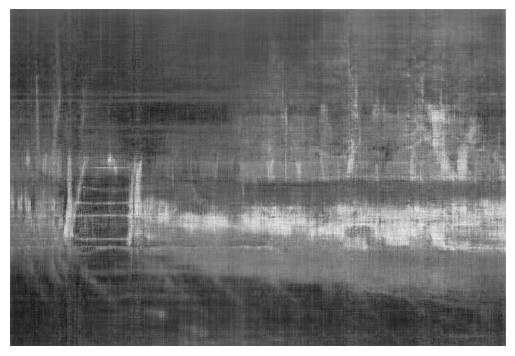

In [132]:
img3 = np.loadtxt('Data/Image3.csv', delimiter=',')
mask3 = np.loadtxt('Data/Mask3.csv', delimiter=',')
# plt.imshow(np.log(img3 * mask3 + 1) + 100000, cmap='Greys')
plt.imshow(img3 * mask3, cmap='Greys')
plt.axis('off')
plt.show()
W3, Z3 = ALS_regularized(img3, 70, mask3, 0.5, max_iter=100)
plt.imshow(W3 @ Z3.T, cmap='Greys')
plt.axis('off')
plt.show()

In [17]:
## Goal 1: Testing
test_range = np.logspace(2, 10, num=200, base=2,dtype=int)
times = []

for n in test_range:
    B = np.random.rand(n, n-2)
    
    start_time = time.time()
    Householder_QR_Factorization(B)
    end_time = time.time()
    times.append(end_time - start_time)

# Log-transform the data
log_n = np.log(test_range)
log_time = np.log(times)

# Perform linear regression to estimate slope
slope1, intercept1, r_value1, _, _ = scipy.stats.linregress(log_n[:50], log_time[:50])
slope2, intercept2, r_value2, _, _ = scipy.stats.linregress(log_n[50:], log_time[50:])

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(log_n, log_time, label='Timing Data', color='blue')
plt.plot(log_n, intercept1 + slope1 * log_n, label=f'Fit Line 1 (slope = {slope1:.2f})', linestyle='--', color='red')
plt.plot(log_n, intercept2 + slope2 * log_n, label=f'Fit Line 2 (slope = {slope2:.2f})', linestyle='--', color='red')

plt.xlabel('log(n)', fontsize=12)
plt.ylabel('log(time)', fontsize=12)
plt.title('Log-Log Plot to Estimate Time Complexity', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

NameError: name 'Householder_QR_Factorization' is not defined